<a href="https://colab.research.google.com/github/Steenos/Ensemble-Methods-for-Range-Localization-via-Over-Water-Electromagnetic-Signals/blob/main/Sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Enhancement of Range Localization via Over-Water Electromagnetic Signals with Esnemble Methods

# Introduction

When a radio signal traverses over the ocean, it bounces through varying levels of humidity, known as evaporation ducts. Contrary to what one might expect, this doesn't mess up the signal. Rather, it's beneficial! 
This distortion lets us differentiate signal measurements over varying distances. So, how exactly do we quantify this? Imagine there's a ship in the middle of the sea emitting a signal, and we're standing at the shore with a receiver, attempting to calculate the ship's distance. Could we even theoretically do that?

Our mission is to devise a function (using machine learning) capable of taking an electromagnetic signal, like a radio wave, and outputting the distance from which the signal originated.

We strive to attain better results with ensemble methods compared to those produced by a neural network.


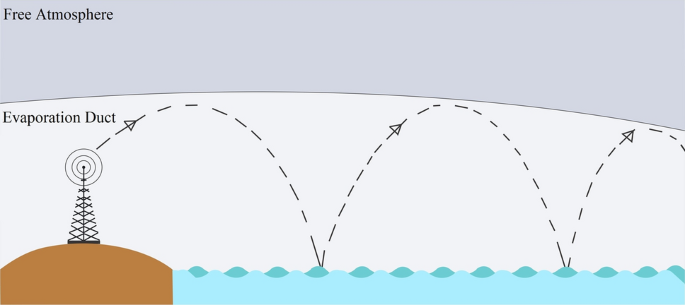

Credit:
Evan Witz, Maria Barger, Randy Paffenroth, Deep Learning for Range Localization via Over-Water Electromagnetic Signals, 2021, ICMLA


Here’s an example of an electromagnetic signal in our dataset that traveled a distance of 15km:
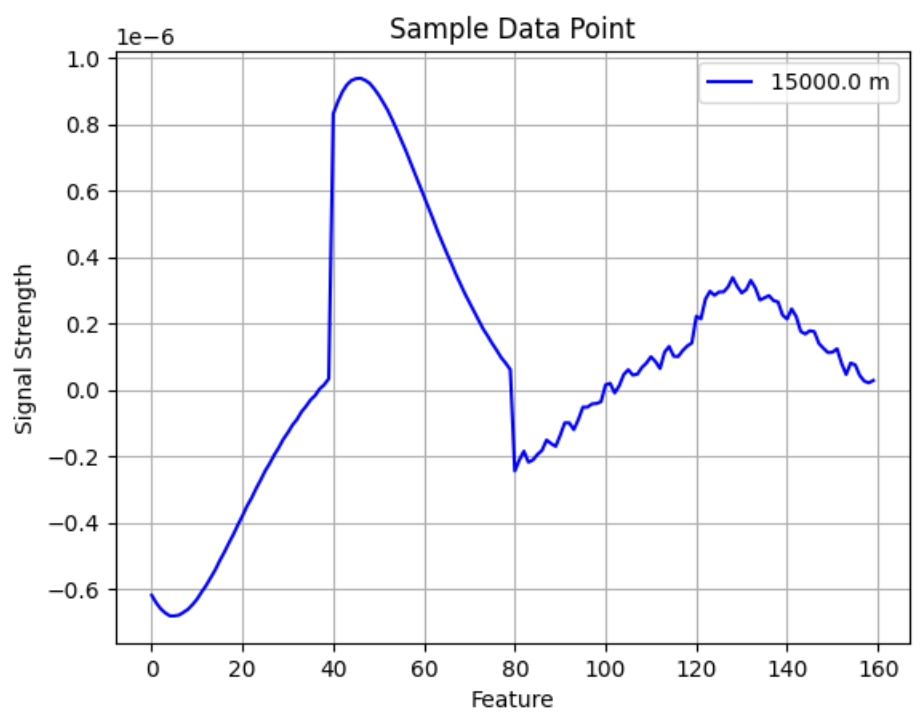


Ultimately, we have a dataset with 1200 individual electromagnetic signals, each with 160 dimensions. So, we have at our disposal 160 features that could assist us in estimating the transmitter's distance.

In the paper “Deep Learning for Range Localization via Over-Water Electromagnetic Signals” The authors pre-process the data by normalizing and rotating the signal before feeding it into a neural network. We plan on also applying a fourier transformation to the signal data as part of pre-processing. 


# Data "Collection"

We're working with simulated signal data generated by a Matlab program (PETOOL) that was injected with Gaussian noise. This data was provided to us by Dr. Paffenroth.

## Import and format data

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import scipy.fft as fft

In [ ]:
# We will simply download the data in h5 format and print its contents
import requests

def download(url: str, output_path: str, mode: str = "wb") -> None:
    res: requests.Response = requests.get(url)
    if res.status_code != 200:
        raise ValueError(f"download of {url} failed with status code {res.status_code}")
    with open(output_path, mode=mode) as fp:
        fp.write(res.content)

download(
    url="https://raw.githubusercontent.com/rcpaffenroth/PIC-Math-Workshop-on-Data-Science-2022/main/data/cs3data1.h5",
    output_path="./cs3data1.h5",
)
download(
    url="https://raw.githubusercontent.com/rcpaffenroth/PIC-Math-Workshop-on-Data-Science-2022/main/data/cs3data2.h5",
    output_path="./cs3data2.h5",
)

arrays={}

# grab the data from the file
filepath = ['cs3data1.h5']
numfiles = len(filepath)
f = 0
for i in range(numfiles):
    f = h5py.File(filepath[i], 'r')
    for k, v in f.items():
        arrays[k] = v

for key, value in arrays.items():
    print(key, value.shape)

duct_height_save (1, 1)
field_H_imag_save (1201, 40)
field_H_real_save (1201, 40)
field_V_imag_save (1201, 40)
field_V_real_save (1201, 40)
range_grid (1201, 1)


In [ ]:
# We have 1201 signals or data points
numranges = 1201

# get the electric field data and reshape everything into one np array
data_h_real = np.array(arrays['field_H_real_save']).reshape(numranges, 40)
data_h_imag = np.array(arrays['field_H_imag_save']).reshape(numranges, 40)
data_v_real = np.array(arrays['field_V_real_save']).reshape(numranges, 40)
data_v_imag = np.array(arrays['field_V_imag_save']).reshape(numranges, 40)

# join the real and imaginary parts into one array
Xraw = []
Xraw += [[data_h_real*1, data_h_imag*1, data_v_real*1, data_v_imag*1]]
Xraw = np.block(Xraw)

# Preprocessing Pipeline

## Normalization

Since some signals are "naturally" weaker than others, the algorithm might think they're far when they're actually close. To account for this, we normalize the data, essentially removing signal strength.

In [ ]:
##### Normalization ######

def normalize(X):
    normedX = np.zeros_like(X)

    # normalize horizontal data
    normedX[:,0:80] = X[:,0:80] / np.linalg.norm(X[:,0:80], axis=1, keepdims=True).reshape((len(X), 1))

    # normalize vertical data
    normedX[:,80:160] = X[:,80:160] / np.linalg.norm(X[:,80:160], axis=1, keepdims=True).reshape((len(X), 1))
    return normedX

X_norm=normalize(Xraw)

## Fourier Transform

Now, we're ready to perform a Fourier Transform, which is a standard step in signal processing. A fourier transform breaks down a signal into its individual components (frequencies). So, for example, if you gave a Fourier Transform a smoothie, it would reverse engineer the smoothie by using various filters, coming up with a recipe!

This is useful because it lets us see how the frequencies are behaving as they bounce off from the duct. High frequencies die off more quickly than lower ones, so if a signal contains a lot of high frequency data, it means it has traveled a shorter distance, and vice versa. It also helps us see how our 160 sensors react to signals. Some sensors might be better at measuring high frequency signals that are close by, and some might be better at measuring low frequency signals that are further away.


![](https://devincody.github.io/Blog/post/an_intuitive_interpretation_of_the_fourier_transform/img/FFT-Time-Frequency-View_hu24c1c8fe894ecd0dad24174b2bed08c9_99850_800x0_resize_lanczos_2.png)



In [ ]:
##### Fourier transform #####

# split the data back into real and imaginary parts
normed_h_real = X_norm[:,0:40]
normed_h_imag = X_norm[:,40:80]
normed_v_real = X_norm[:,80:120]
normed_v_imag = X_norm[:,120:160]

# combine the real and imaginary parts into complex numbers
data_h = np.vectorize(complex)(normed_h_real, normed_h_imag)
data_v = np.vectorize(complex)(normed_v_real, normed_v_imag)

# perform the fourier transform
h_fourier = fft.fft(data_h)
v_fourier = fft.fft(data_v)

# get the real and imaginary parts (this will be used later on for the plots)
h_fourier_real = np.real(h_fourier)
v_fourier_real = np.real(v_fourier)
h_fourier_imag = np.imag(h_fourier)
v_fourier_imag = np.imag(v_fourier)

# get the labels
Yraw = np.array(arrays['range_grid']).reshape(1201, 1)

# get the frequency data
freq = fft.fftfreq(numranges, d=0.1).reshape(-1,1)


## Fourier Normalization

Performing a Fourier Transform might introduce or amplify some noise or bias in our the data. Because of this, we'll have to normalize the data again.

However, the right way to normalize a Fourier Transform is to divide the vectors by the biggest magnitude in the data (instead of dividing by the norm).

In [ ]:
##### Fourier Normalization #####

# get the magnitude data
h_mag = np.abs(h_fourier)
v_mag = np.abs(v_fourier)

# normalize the signals by using the max magnitude
h_fourier_normed = h_fourier / np.max(h_mag)
v_fourier_normed = v_fourier / np.max(v_mag)

## Standardization

The next step to preprocessing our data is to standardize. This is basically rescaling data to have a mean of 0 and standard deviation of 1 (so all of our data will fit between 1 and 0).

Why do we perform so many normalization and standardization operations? Because some algorithms are sensitive to noise. Doing these procedures also helps us focus on the features we want and shapes the data to be what we want it to be.

In [ ]:
from sklearn.preprocessing import StandardScaler

# split the data into real and imaginary parts
final_h_real = np.real(h_fourier_normed)
final_h_imag = np.imag(h_fourier_normed)
final_v_real = np.real(v_fourier_normed)
final_v_imag = np.imag(v_fourier_normed)

# standardize the data (adjust data to have mean=0 and sd=1)
scaler = StandardScaler()
final_h_real = scaler.fit_transform(final_h_real)
scaler = StandardScaler()
final_h_imag = scaler.fit_transform(final_h_imag)
scaler = StandardScaler()
final_v_real = scaler.fit_transform(final_v_real)
scaler = StandardScaler()
final_v_imag = scaler.fit_transform(final_v_imag)

X_std = np.concatenate((final_h_real, final_h_imag, final_v_real, final_v_imag), axis=1)

## Rotation

The final step in our preprocessing pipeline is to rotate the data and append the frequency array. We rotate the data because signals that are close to each other don't look similar. This might confuse the ML algorithm, so we account for this by ensuring similar signals (i.e. with similar distances) have similar features.

We append the frequency data because it's one of the most valuable pieces of information **we** gain from the Fourier Transform.

In [ ]:
def rotate(X):
    rows = X.shape[0]
    cols = X.shape[1]
    output = np.zeros_like(X)
    for i in range(rows):
        angle = np.arctan(X[i,80]/X[i,0])
        realparts = X[i,0:40]
        imagparts = X[i,40:80]
        output[i,0:40] = np.cos(angle)*realparts + np.sin(angle) * imagparts
        output[i,40:80] = -np.sin(angle)*realparts + np.cos(angle) * imagparts
        realparts = X[i,80:120]
        imagparts = X[i,120:160]
        output[i,80:120] = np.cos(angle)*realparts + np.sin(angle) * imagparts
        output[i,120:160] = -np.sin(angle)*realparts + np.cos(angle) * imagparts
    return output

X_in = rotate(X_std)

# Feature Extraction

Although we didn't dive deeper into this step, the Fourier Transform provided us with some great information. Among the information we got from the Transform, we found that the frequency data was especially valuable.

In [ ]:
# we append the freq array to our final array
X_in = np.concatenate((freq, X_in), axis=1)

# EDA and Data Visualization

Now, it's time to understand what's going on with the data, we'll first show the shape of our arrays and then show the plots.

## Shape of data

In [ ]:
from tabulate import tabulate

usedata = [("X_std", X_std), ("freq", freq), ("X_in (final input)", X_in)]
transforms = [("h_fourier (complex)", h_fourier), ("v_fourier (complex)", v_fourier), ("h_fourier_real", h_fourier_real), ("h_fourier_imag", h_fourier_imag), ("v_fourier_real", v_fourier_real), ("v_fourier_imag", v_fourier_imag), ("h_mag", h_mag), ("v_mag", v_mag)]

def get_shape(data):
  table = []
  for i in range(len(data)):
      table.append([data[i][0], data[i][1].shape])
  print(tabulate(table, headers=["Dataset Name", "Shape"]))
  return
    
get_shape(usedata)
print("\n")
get_shape(transforms)

Dataset Name        Shape
------------------  -----------
X_std               (1201, 160)
freq                (1201, 1)
X_in (final input)  (1201, 161)


Dataset Name         Shape
-------------------  ----------
h_fourier (complex)  (1201, 40)
v_fourier (complex)  (1201, 40)
h_fourier_real       (1201, 40)
h_fourier_imag       (1201, 40)
v_fourier_real       (1201, 40)
v_fourier_imag       (1201, 40)
h_mag                (1201, 40)
v_mag                (1201, 40)


# Visualizations

### Raw Data

First, let's take a look at the raw data from one of our 160 sensors. What we're seeing is not an individual signal, but rather, all of the signals a receiver can detect. We're essentially looking at the range of a receiver, which in this case, was good at measuring short distance signals.

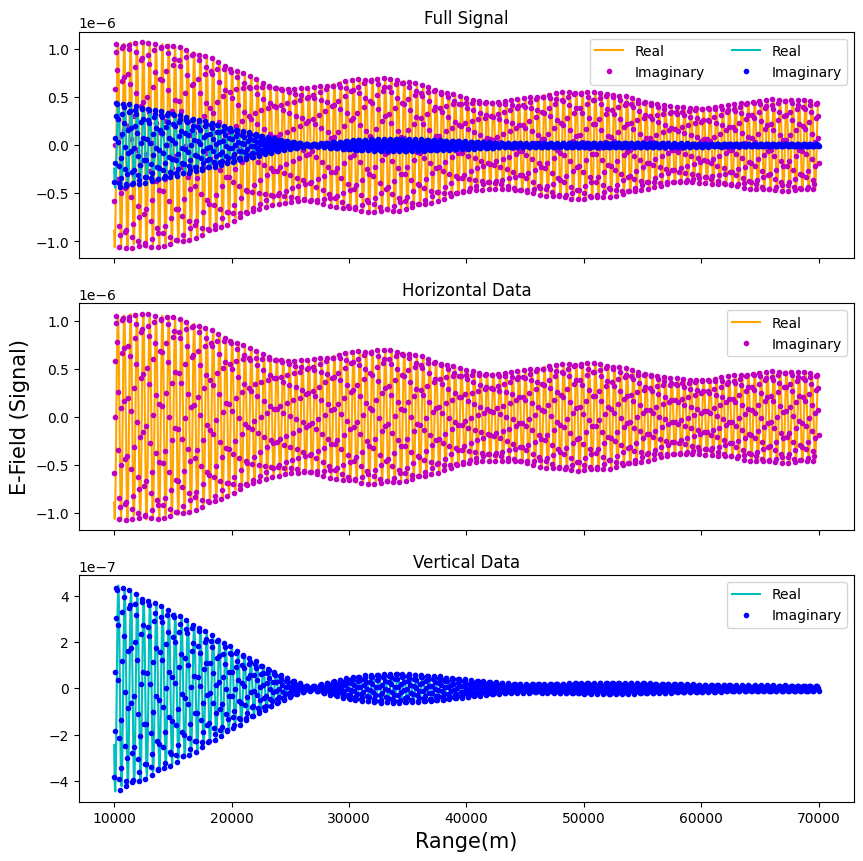

In [ ]:
###### Raw data ######
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,10))

ax1.plot(Yraw, data_h_real[:,0], 'orange', Yraw, data_h_imag[:,0], 'm.')
ax1.plot(Yraw, data_v_real[:,0], 'c', Yraw, data_v_imag[:,0], 'b.')
ax1.set_title('Full Signal')

ax2.plot(Yraw, data_h_real[:,0], 'orange', label='Real')
ax2.plot(Yraw, data_h_imag[:,0], 'm.', label='Imaginary')
ax2.legend()
ax2.set_ylabel('E-Field (Signal)', size=15.0)
ax2.set_title('Horizontal Data')

ax3.plot(Yraw, data_v_real[:,0], 'c', label='Real')
ax3.plot(Yraw, data_v_imag[:,0], 'b.', label='Imaginary')
ax3.legend()
ax3.set_xlabel('Range(m)', size=15.0)
ax3.set_title('Vertical Data')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, ncol=2)
plt.show()

### Normalized Data

Now, let's look at the normalized data, right before performing the Fourier Transform. You'll notice that this receiver now has a better and wider range, detecting signals from 70000 km away.

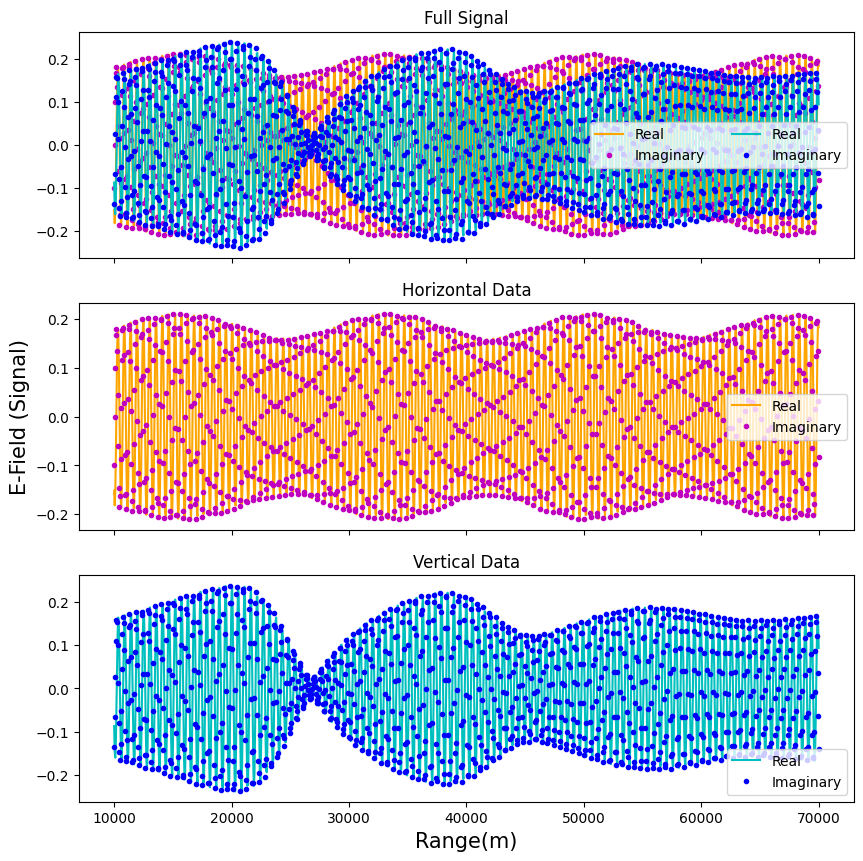

In [ ]:
####### Normalized data #######
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,10))

ax1.plot(Yraw, normed_h_real[:,0], 'orange', Yraw, normed_h_imag[:,0], 'm.')
ax1.plot(Yraw, normed_v_real[:,0], 'c', Yraw, normed_v_imag[:,0], 'b.')
ax1.set_title('Full Signal')

ax2.plot(Yraw, normed_h_real[:,0], 'orange', label='Real')
ax2.plot(Yraw, normed_h_imag[:,0], 'm.', label='Imaginary')
ax2.legend()
ax2.set_ylabel('E-Field (Signal)', size=15.0)
ax2.set_title('Horizontal Data')

ax3.plot(Yraw, normed_v_real[:,0], 'c', label='Real')
ax3.plot(Yraw, normed_v_imag[:,0], 'b.', label='Imaginary')
ax3.legend()
ax3.set_xlabel('Range(m)', size=15.0)
ax3.set_title('Vertical Data')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, ncol=2)
plt.show()

### Fourier Transform

Now, the data after the Fourier Transform. Remember how the normalization gave the receiver more "power" and range? The Fourier Transform takes away a bit of that range, but now we have a more accurate representation of what kind of signals our receiver can "see". You can also see that it's good at measuring horizontal signals, but not vertical ones.

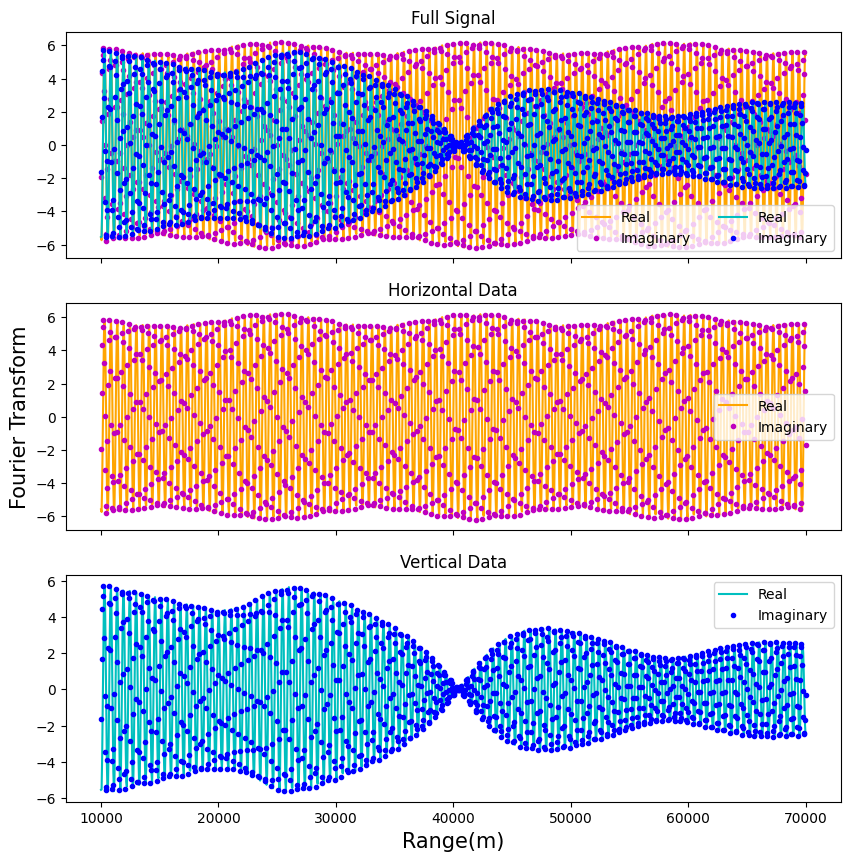

In [ ]:
###### Data after Fourier transform ######
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,10))

ax1.plot(Yraw, h_fourier_real[:,0], 'orange', Yraw, h_fourier_imag[:,0], 'm.')
ax1.plot(Yraw, v_fourier_real[:,0], 'c', Yraw, v_fourier_imag[:,0], 'b.')
ax1.set_title('Full Signal')

ax2.plot(Yraw, h_fourier_real[:,0], 'orange', label='Real')
ax2.plot(Yraw, h_fourier_imag[:,0], 'm.', label='Imaginary')
ax2.legend()
ax2.set_ylabel('Fourier Transform', size=15.0)
ax2.set_title('Horizontal Data')

ax3.plot(Yraw, v_fourier_real[:,0], 'c', label='Real')
ax3.plot(Yraw, v_fourier_imag[:,0], 'b.', label='Imaginary')
ax3.legend()
ax3.set_xlabel('Range(m)', size=15.0)
ax3.set_title('Vertical Data')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, ncol=2)
plt.show()

### "Proper" Fourier Graph

A "proper" Fourier Graph usually shows the Signal in terms of Frequency. Just for fun, let's visualize it. You'll see there's some weird lines that cut through, but you'll also notice this is the same graph as above. The leftmost part are the further frequencies, and the rightmost are the closer frequencies.

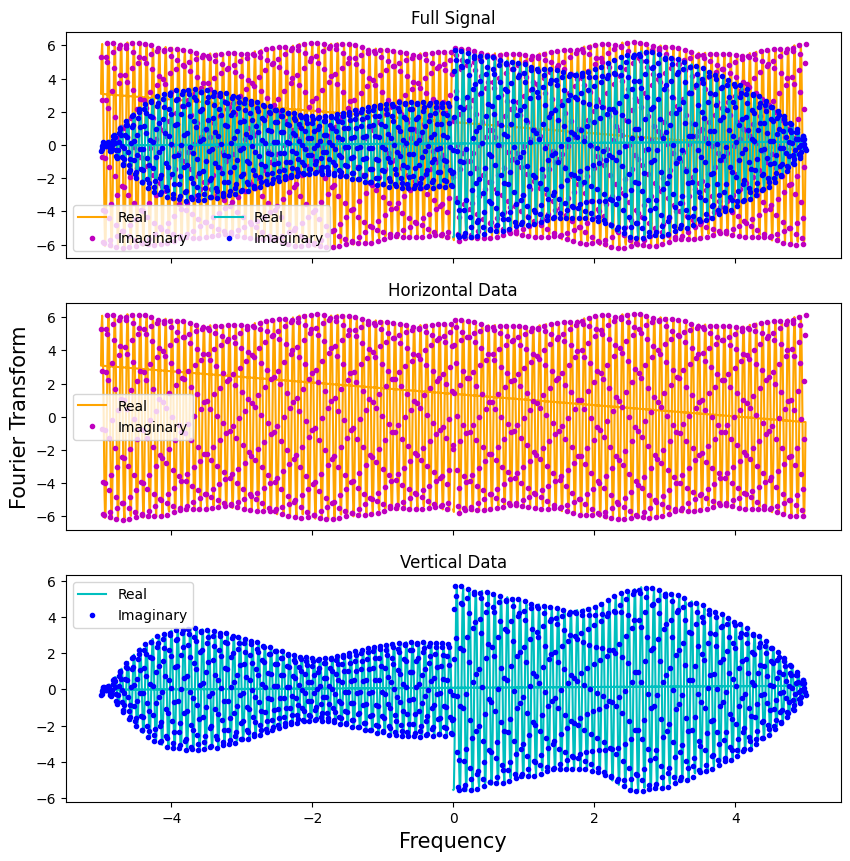

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,10))

ax1.plot(freq, h_fourier_real[:,0], 'orange', freq, h_fourier_imag[:,0], 'm.')
ax1.plot(freq, v_fourier_real[:,0], 'c', freq, v_fourier_imag[:,0], 'b.')
ax1.set_title('Full Signal')

ax2.plot(freq, h_fourier_real[:,0], 'orange', label='Real')
ax2.plot(freq, h_fourier_imag[:,0], 'm.', label='Imaginary')
ax2.legend()
ax2.set_ylabel('Fourier Transform', size=15.0)
ax2.set_title('Horizontal Data')

ax3.plot(freq, v_fourier_real[:,0], 'c', label='Real')
ax3.plot(freq, v_fourier_imag[:,0], 'b.', label='Imaginary')
ax3.legend()
ax3.set_xlabel('Frequency', size=15.0)
ax3.set_title('Vertical Data')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, ncol=2)
plt.show()

# Applying Machine Learning Algorithms

Ensemble methods in machine learning are strategies that combine multiple models (aka base estimators) to improve predictive performance. Often the base estimators are Decision Trees.
 The idea is similar to the wisdom of the crowd, where a collective opinion is better than an individual one.

Think of ensemble methods as the equivalent of studying for a big exam. You could study from one textbook, and you might do okay. But if you study from multiple textbooks, some online resources, and join a study group, you're likely to have a better understanding of the material and perform better on the exam. In the same way, ensemble methods combine predictions from multiple machine learning models to improve the final result.


## XGBoost

XGBoost, short for "Extreme Gradient Boosting", consists of a series of models, where each new model pays more attention to the data points that were incorrectly predicted by the previous models. This way, the algorithm improves its predictions iteratively. 

Keep in mind that all the models in gradient boosting are decision trees.
The nodes in each decision tree take a different subset of features for selecting the best split. Because each individual tree is different, they each capture different signals from the data.The final prediction is a weighted sum of the predictions made by previous models.


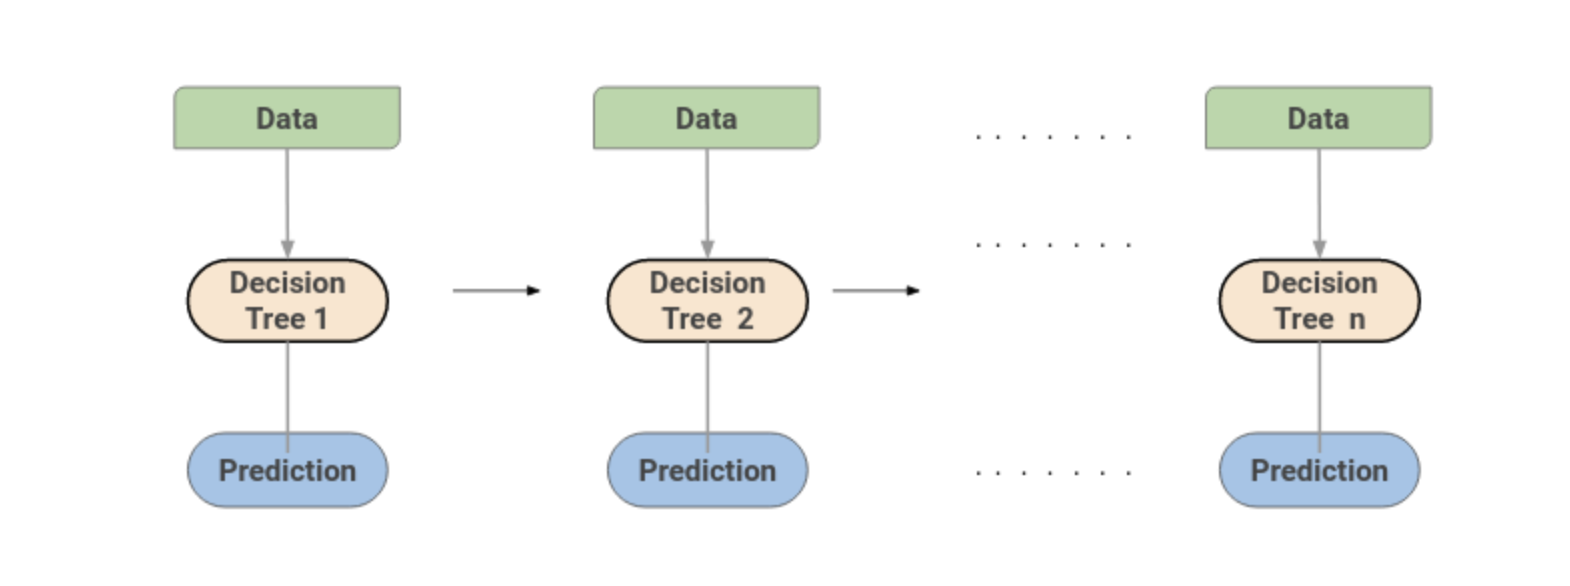

## Hyperparameter Optimization

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

parameters = {'max_depth':[3], 'n_estimators':[100], 'min_child_weight':[70], 'gamma':[1],
              'learning_rate': [0.3], 'objective':['reg:squarederror'], 'subsample':[0.5,1]}

nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(xgb.XGBRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(X_in,Yraw)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params, best score: 0.9909 {'gamma': 1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 70, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}


In [ ]:
# Now we'll repeat this process for Random Forest, Gradient Boosting, and AdaBoost
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

Yraw_df = pd.DataFrame(Yraw)

# Random Forest
parameters = {'max_depth':[3], 'n_estimators':[100], 'min_samples_leaf':[70], 'min_samples_split':[2],
                'max_features':[1.0], 'bootstrap':[True], 'oob_score':[True]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                        verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(X_in,Yraw_df.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
        model.best_params_)

# Gradient Boosting
parameters = {'max_depth':[3], 'n_estimators':[100], 'min_samples_leaf':[70], 'min_samples_split':[2], \
              'max_features':[1.0], 'learning_rate':[0.3]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(GradientBoostingRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                        verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(X_in,Yraw_df.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
        model.best_params_)

# AdaBoost
parameters = {'n_estimators':[100], 'learning_rate':[0.3]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(AdaBoostRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                        verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(X_in,Yraw_df.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
        model.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params, best score: 0.9804 {'bootstrap': True, 'max_depth': 3, 'max_features': 1.0, 'min_samples_leaf': 70, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params, best score: 0.9895 {'learning_rate': 0.3, 'max_depth': 3, 'max_features': 1.0, 'min_samples_leaf': 70, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params, best score: 0.9859 {'learning_rate': 0.3, 'n_estimators': 100}


# Final Scores

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

Yraw_df = pd.DataFrame(Yraw)

models = [XGBRegressor(gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=70, n_estimators=5, objective='reg:squarederror', subsample=1), RandomForestRegressor(), \
            GradientBoostingRegressor(), AdaBoostRegressor()]

model_names = ['XGBoost', 'Random Forest', 'Gradient Boosting', 'AdaBoost']

results = []
for i in range(len(models)):
    scores = cross_val_score(models[i], X_in, Yraw_df.values.ravel(), cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results.append([model_names[i], mean_score, std_score])

headers = ['Model', 'Mean R^2', 'Std R^2']
print(tabulate(results, headers=headers, floatfmt=".8f"))


Model                Mean R^2     Std R^2
-----------------  ----------  ----------
XGBoost            0.80063053  0.01442230
Random Forest      0.99257626  0.01271996
Gradient Boosting  0.98933720  0.02117545
AdaBoost           0.97819669  0.01717387


# Training Graphs

Now, let's see how each model's performance changes as we train it!

## XGBoost

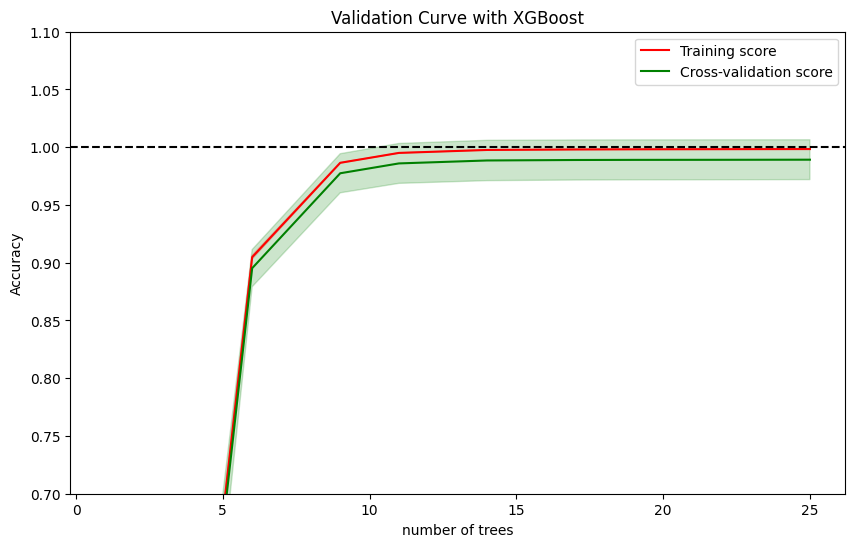

Best cross-validation result (0.99) obtained for 25 trees


In [ ]:
from sklearn.model_selection import validation_curve

n_estimators_range = np.linspace(1, 25, 10).astype('int')

#params = {'alpha': 0, 'colsample_bytree': 0.6, 'gamma': 1, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 50, 'objective': 'reg:squarederror', 'subsample':.7}
params = {'gamma': 1, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 70, 'n_estimators': 5, 'objective': 'reg:squarederror', 'subsample': 1}
train_scores, test_scores = validation_curve(
    XGBRegressor(**params),
    test, Yraw_df.values.ravel(),
    scoring='r2',
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv = KFold(n_splits=5, shuffle=True) , error_score="raise"
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean,
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

### Gradient Boosting

### Random Forest

### AdaBoost

# Next Steps

We didn't perform any PCA, ICA, or clustering, which were some methods we considered. This might improve our performance even further, especially ICA and clustering, since it'll group our signals by similarity.

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=160)  
# reduced_features = pca.fit_transform(X_in) # feature engineering